In [200]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from pathlib import Path
from numpy.random import randint
from numpy.random import shuffle
from itertools import islice
from typing import Any
from numpy import ndarray, number, average, median, var, array
from src.utils.image_operations import rgb2channel
from imageio import imread

In [251]:
from skimage.filters.ridges import sato
from skimage.morphology import disk, erosion
from src.utils.image_operations import normalize_histogram, sharpen, create_mask, apply_mask
directory = "../public/eye/photos"

pairs = [(f"{directory}/{path.stem}.jpg", f"{directory}/{path.stem}.tif") for path in Path(directory).glob("*.jpg")]

RgbArray = ndarray[(Any, Any, 3), number]
LArray = ndarray[(Any, Any), number]

def pick_pair(pairs: [(str, str)]) -> (str, str):
  return pairs[randint(0, len(pairs))]

def process_pair(pair: (str, str)) -> (LArray, LArray):
  (image, expert) = pair
  green = rgb2channel(imread(image), 'green')
  mask = create_mask(green)

  image = normalize_histogram(sharpen(green))
  image = apply_mask(sato(image), mask)
  expert = imread(expert) > 0
  return (image, expert)

def pick_section(image: LArray, expert: LArray, diameter: int, decision: bool) -> (LArray, LArray):
  (width, height) = image.shape
  radius = diameter // 2

  while expert[x := randint(radius, width - diameter), y := randint(radius, height - diameter)] != decision: pass
  return (image[x - radius:x + radius, y - radius:y + radius], expert[x, y])

In [ ]:
def create_generator(image: LArray, expert: LArray, diameter: int, decision: bool):
  (width, height) = image.shape
  radius = diameter // 2

  while True:
    while expert[x := randint(radius, width - diameter), y := randint(radius, height - diameter)] != decision: pass
    section = image[x - radius:x + radius, y - radius:y + radius]
    yield ((average(section), median(section), var(section)), expert[x, y])

def create_batch(pair: (LArray, LArray), diameter: int, batchsize: int, balance_ratio: float):
  valid = int(batchsize * balance_ratio)
  invalid = int(batchsize - valid)

  (image, expert) = pair

  shuffle(batch := [
    *islice(create_generator(image, expert, diameter, True), valid),
    *islice(create_generator(image, expert, diameter, False), invalid),
  ])

  return (array([x for (x, _) in batch]), array([y for (_, y) in batch]))

def create_batch_generator(pairs: [(LArray, LArray)], diameter: int, batchsize: int, balance_ratio: float):
  while True:
    yield create_batch(process_pair(pick_pair(pairs)), diameter, batchsize, balance_ratio)

In [259]:
def create_trained_classifier(pairs: [(LArray, LArray)], diameter: int, batchsize: int, balance_ratio: float,
                              epochs: int):
  generator = create_batch_generator(pairs, diameter, batchsize, balance_ratio)
  print("Preparing batches...")
  batches = list([(print(f"Created batch: {epoch}/{epochs}"), batch)[1] for (epoch, batch) in enumerate(islice(generator, epochs), start=1)])

  print("Preparing X...")
  X = array([x for (x, _) in batches])
  X = X.reshape(-1, X.shape[-1])
  print("X shape:", X.shape)

  print("Preparing y...")
  y = array([y for (_, y) in batches]).flatten()
  print("y shape:", y.shape)

  print("Fitting model...")
  classifier = DecisionTreeClassifier(max_depth=8)
  classifier.fit(X, y)

  print(f"Validation Accuracy: {classifier.score(*next(generator))}")
  return classifier

In [265]:
classifier = create_trained_classifier(pairs, 5, 1028, 0.5, 16)

Preparing batches...
Created batch: 1/16
Created batch: 2/16
Created batch: 3/16
Created batch: 4/16
Created batch: 5/16
Created batch: 6/16
Created batch: 7/16
Created batch: 8/16
Created batch: 9/16
Created batch: 10/16
Created batch: 11/16
Created batch: 12/16
Created batch: 13/16
Created batch: 14/16
Created batch: 15/16
Created batch: 16/16
Preparing X...
X shape: (16448, 3)
Preparing y...
y shape: (16448,)
Fitting model...
Validation Accuracy: 0.8608949416342413


In [ ]:
batch = create_batch(process_pair(pick_pair(pairs)), 5, 512, 0.5)
batch

0/2336
1/2336
2/2336
3/2336
4/2336
5/2336
6/2336
7/2336
8/2336
9/2336
10/2336
11/2336
12/2336
13/2336
14/2336
15/2336
16/2336
17/2336
18/2336
19/2336
20/2336
21/2336
22/2336
23/2336
24/2336
25/2336
26/2336
27/2336
28/2336
29/2336
30/2336
31/2336
32/2336
33/2336
34/2336
35/2336
36/2336
37/2336
38/2336
39/2336
40/2336
41/2336
42/2336
43/2336
44/2336
45/2336
46/2336
47/2336
48/2336
49/2336
50/2336
51/2336
52/2336
53/2336
54/2336
55/2336
56/2336
57/2336
58/2336
59/2336
60/2336
61/2336
62/2336
63/2336
64/2336
65/2336
66/2336
67/2336
68/2336
69/2336
70/2336
71/2336
72/2336
73/2336
74/2336
75/2336
76/2336
77/2336
78/2336
79/2336
80/2336
81/2336
82/2336
83/2336
84/2336
85/2336
86/2336
87/2336
88/2336
89/2336
90/2336
91/2336
92/2336
93/2336
94/2336
95/2336
96/2336
97/2336
98/2336
99/2336
100/2336
101/2336
102/2336
103/2336
104/2336
105/2336
106/2336
107/2336
108/2336
109/2336
110/2336
111/2336
112/2336
113/2336
114/2336
115/2336
116/2336
117/2336
118/2336
119/2336
120/2336
121/2336
122/2336
123

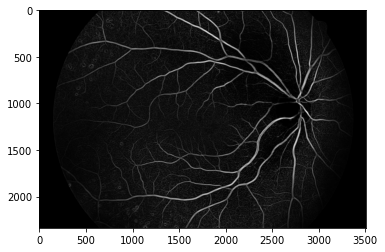

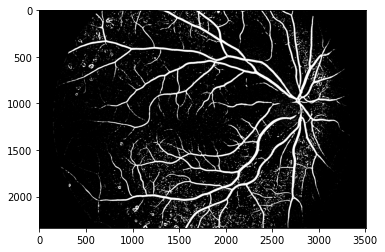

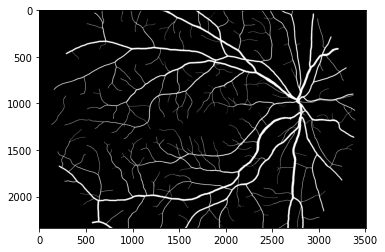

In [266]:
from numpy import zeros, pad
classifier.score(*batch)

(image, expert) = process_pair(pick_pair(pairs))
diameter = 5
radius = diameter // 2
(width, height) = image.shape
padded = pad(image, radius)

prediction_image = zeros((width, height))

for x in range(0, width):
  print(f"{x}/{width}")
  metrics = [(average(section), median(section), var(section))
             for section in
             [padded[x:x + diameter, y:y + diameter] for y in range(0, height)]]
  prediction_image[x, :] = classifier.predict(metrics)

plt.show(plt.imshow(image, cmap='gray'))
plt.show(plt.imshow(prediction_image, cmap='gray'))
plt.show(plt.imshow(expert, cmap='gray'))

0/584
1/584
2/584
3/584
4/584
5/584
6/584
7/584
8/584
9/584
10/584
11/584
12/584
13/584
14/584
15/584
16/584
17/584
18/584
19/584
20/584
21/584
22/584
23/584
24/584
25/584
26/584
27/584
28/584
29/584
30/584
31/584
32/584
33/584
34/584
35/584
36/584
37/584
38/584
39/584
40/584
41/584
42/584
43/584
44/584
45/584
46/584
47/584
48/584
49/584
50/584
51/584
52/584
53/584
54/584
55/584
56/584
57/584
58/584
59/584
60/584
61/584
62/584
63/584
64/584
65/584
66/584
67/584
68/584
69/584
70/584
71/584
72/584
73/584
74/584
75/584
76/584
77/584
78/584
79/584
80/584
81/584
82/584
83/584
84/584
85/584
86/584
87/584
88/584
89/584
90/584
91/584
92/584
93/584
94/584
95/584
96/584
97/584
98/584
99/584
100/584
101/584
102/584
103/584
104/584
105/584
106/584
107/584
108/584
109/584
110/584
111/584
112/584
113/584
114/584
115/584
116/584
117/584
118/584
119/584
120/584
121/584
122/584
123/584
124/584
125/584
126/584
127/584
128/584
129/584
130/584
131/584
132/584
133/584
134/584
135/584
136/584
137/584
138/58

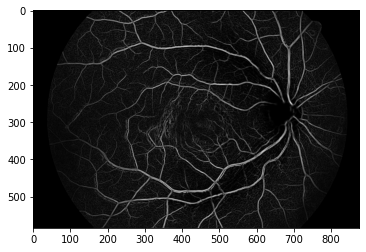

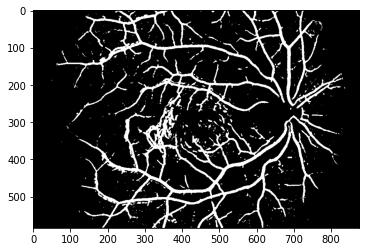

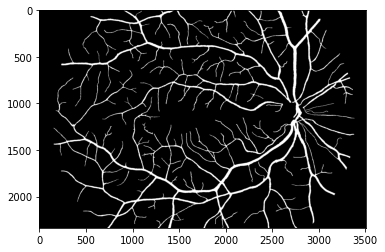

In [273]:
import cv2
from numpy import zeros, pad

(image, expert) = process_pair(pick_pair(pairs))

image = cv2.resize(image, (int(image.shape[1] * 0.25), int(image.shape[0] * 0.25)))
diameter = 5
radius = diameter // 2
(width, height) = image.shape
padded = pad(image, radius)

prediction_image = zeros((width, height))
for x in range(0, width):
  print(f"{x}/{width}")
  metrics = [(average(section), median(section), var(section))
             for section in
             [padded[x:x + diameter, y:y + diameter] for y in range(0, height)]]
  prediction_image[x, :] = classifier.predict(metrics)

plt.show(plt.imshow(image, cmap='gray'))
plt.show(plt.imshow(prediction_image, cmap='gray'))
plt.show(plt.imshow(expert, cmap='gray'))

In [271]:
classifier.get_params(deep=True)
import pickle

with open("decision_tree_classifier_model_5.pkl", "wb") as file:
  pickle.dump(classifier, file)

In [272]:
with open("decision_tree_classifier_model.pkl", "rb") as file:
  classifier = pickle.load(file)
